<a href="https://colab.research.google.com/github/drcjaudet/Deconvolution3D/blob/master/CycyauTop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install SimpleITK pydicom tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 80.3 MB/s eta 0:00:00


Using device: cuda


 10%|█         | 1/10 [00:00<00:06,  1.41it/s]

Epoch 1/10, Train Loss: 0.2340, Val Loss: 0.2160


 20%|██        | 2/10 [00:01<00:05,  1.50it/s]

Epoch 2/10, Train Loss: 0.2020, Val Loss: 0.1367


 30%|███       | 3/10 [00:01<00:04,  1.55it/s]

Epoch 3/10, Train Loss: 0.1009, Val Loss: 0.0118


 40%|████      | 4/10 [00:02<00:03,  1.57it/s]

Epoch 4/10, Train Loss: 0.0062, Val Loss: 0.0001


 50%|█████     | 5/10 [00:03<00:03,  1.58it/s]

Epoch 5/10, Train Loss: 0.0000, Val Loss: 0.0000


 60%|██████    | 6/10 [00:03<00:02,  1.58it/s]

Epoch 6/10, Train Loss: 0.0000, Val Loss: 0.0000


 70%|███████   | 7/10 [00:04<00:01,  1.58it/s]

Epoch 7/10, Train Loss: 0.0000, Val Loss: 0.0000


 80%|████████  | 8/10 [00:05<00:01,  1.59it/s]

Epoch 8/10, Train Loss: 0.0000, Val Loss: 0.0000


 90%|█████████ | 9/10 [00:05<00:00,  1.60it/s]

Epoch 9/10, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 10/10 [00:06<00:00,  1.58it/s]

Epoch 10/10, Train Loss: 0.0000, Val Loss: 0.0000


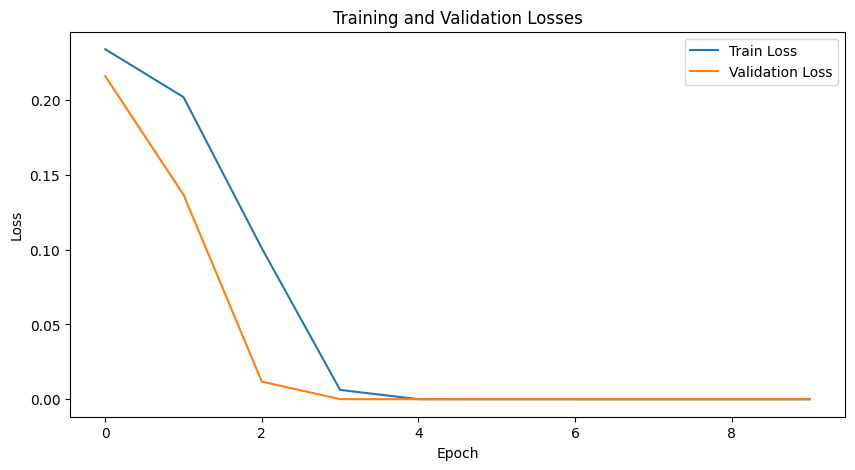

In [53]:
import os
import SimpleITK as sitk
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import v2 as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import copy
import pydicom
import random
import numpy as np
from tqdm import tqdm

#utilise les GPU sinon CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def norm_numpy_matrice(data):
  min_val = np.min(data)
  max_val = np.max(data)
  scaled_data = (data - min_val) / (max_val - min_val)
  #print("Normalisation: ok")
  return scaled_data

# Function to read DICOM files and convert to tensors
def load_dicom_folder(folder_path):
    images = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".dcm") or file_name.endswith(".DCM"):
            file_path = os.path.join(folder_path, file_name)
            ds = pydicom.dcmread(file_path)
            image = sitk.GetArrayFromImage(sitk.ReadImage(file_path))
            image=np.transpose(image, (2,1,0))#l 'image doit être convertie en HWC
            transform_cycy=gettransform()
            image=transform_cycy(image)
            #print(image.shape)
            images.append(image)
    return images

def gettransform():
    transform_cycy = transforms.Compose([
        transforms.ToImage(), #convertie l'image en tensor r numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W)
        transforms.ToDtype(torch.float32, scale=False), #+normalisaiton entre 0 et 1 si Scale=true
        transforms.Lambda(lambda x: x/1000), #rajouter la normalisation dasn kes transform normalisation par 1000
         #transforms.Normalize(mean=0.5, std=0.5) #utiliser torch.clamp
    ])
    return transform_cycy

# Function to add Gaussian and Poisson noise
def add_gaussian_poisson_noise(image, gaussian_std=0.1, poisson_lam=10.0):
    gaussian_noise = torch.randn_like(image) * gaussian_std
    poisson_noise = torch.poisson(image * poisson_lam) / poisson_lam - image
    noisy_image = image + gaussian_noise + poisson_noise
    #clip or normalise the image?
    return noisy_image

# Custom Dataset class
class NoisyImageDataset(Dataset):
    def __init__(self, images, transform=None, gaussian_std=0.1, poisson_lam=10.0):
        self.images = images
        self.transform = transform
        self.gaussian_std = gaussian_std
        self.poisson_lam = poisson_lam

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        noisy_image_1 = add_gaussian_poisson_noise(image, self.gaussian_std, self.poisson_lam)
        noisy_image_2 = add_gaussian_poisson_noise(image, self.gaussian_std, self.poisson_lam)

        if self.transform:
            noisy_image_1 = self.transform(noisy_image_1)
            noisy_image_2 = self.transform(noisy_image_2)

        return noisy_image_1, noisy_image_2, image

# Denoising CNN model
class DenoisingCNN(nn.Module):
    def __init__(self):
        super(DenoisingCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(), #changer to Silu
            nn.Conv2d(64,64, kernel_size=3, padding=1), #utiliser Group norm?
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2)
        )
        self.middle = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        #x = F.interpolate(x, scale_factor=2, mode='nearest') #enlever ainsi que le max pooling
        x = self.decoder(x)
        return x

# Main training script
def train_denoising_model(dicom_folder, num_epochs=10, batch_size=8, gaussian_std=0.1, poisson_lam=10.0):
    # Load DICOM images
    images = load_dicom_folder(dicom_folder)

    # Define dataset and dataloaders
    #transform = transforms.Compose([transforms.Normalize(mean=0.5, std=0.5)])
    transform_cycy=gettransform()
    dataset = NoisyImageDataset(images, transform_cycy, gaussian_std, poisson_lam)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Define model, loss function, and optimizer
    model = DenoisingCNN()
    model=model.to(device)
    criterion = nn.MSELoss() # Huber Loss   nn.SmoothL1Loss() instead of nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001) #AdamW ou Adam

    # Training loop with validation and model saving
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_train_loss = 0.0
        for noisy_image_1, noisy_image_2, _ in train_dataloader:
            noisy_image_1, noisy_image_2 = noisy_image_1.to(device), noisy_image_2.to(device)
            optimizer.zero_grad()
            outputs = model(noisy_image_1)
            loss = criterion(outputs, noisy_image_2)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        epoch_train_loss = running_train_loss / len(train_dataloader)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for noisy_image_1, noisy_image_2, _ in val_dataloader:
                noisy_image_1, noisy_image_2 = noisy_image_1.to(device), noisy_image_2.to(device)
                outputs = model(noisy_image_1)
                loss = criterion(outputs, noisy_image_2)
                running_val_loss += loss.item()

        epoch_val_loss = running_val_loss / len(val_dataloader)
        val_losses.append(epoch_val_loss)

        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

    # Save the best model weights
    torch.save(best_model_wts, 'best_denoising_model.pth')

    # Plot the training and validation losses
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses')
    plt.show()

    # Load the best model weights
    model.load_state_dict(best_model_wts)

    return model, val_dataloader


# Example usage
dicom_folder = '/content/2'
model, val_dataloader = train_denoising_model(dicom_folder)




torch.Size([1, 288, 288])
0.4311128
9.565097e-21
(288, 288)
0.2990572


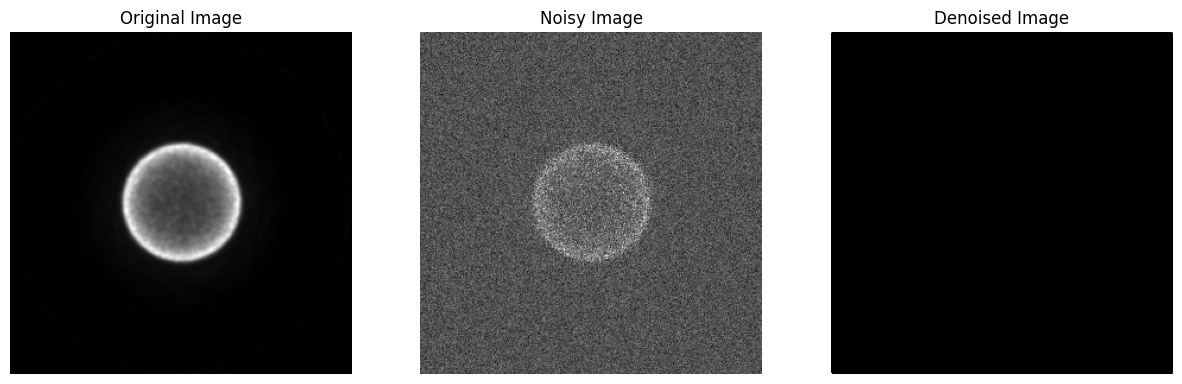

In [50]:

# Function to visualize denoising on a random image
def visualize_denoising(model, dataloader):
    model.eval()
    with torch.no_grad():
        # Get a random batch
        noisy_image_1, noisy_image_2, original_image = next(iter(dataloader))
        #noisy_image_1, _, original_image = dataloader.dataset[1]

        # Select a random image from the batch
        idx = random.randint(0, noisy_image_1.size(0) - 1)
        noisy_image = noisy_image_1[idx]#.unsqueeze(0)
        noisy_image = noisy_image.to(device)
        original_image = original_image[idx]#.unsqueeze(0)

        # Get the denoised image
        denoised_image = model(noisy_image)
        print(denoised_image.shape)

        # Move tensors to CPU and remove channel dimension
        noisy_image = noisy_image.squeeze().cpu().numpy()
        original_image = original_image.squeeze().cpu().numpy()
        denoised_image = denoised_image.squeeze().cpu().numpy()

        denoised_image=denoised_image*1000
        print(np.max(denoised_image))
        print(np.min(denoised_image))
        print(denoised_image.shape)
        print(np.max(original_image))

        # Plot the images
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(original_image, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Noisy Image")
        plt.imshow(noisy_image, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Denoised Image")
        plt.imshow(denoised_image, cmap='gray')
        plt.axis('off')

        plt.show()

# Visualize the denoising
visualize_denoising(model, val_dataloader)